In [ ]:
import sys
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Garante que a raiz do projeto esteja no PYTHONPATH
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.paths import *
from src.config import *
from src.io import *

create_project_structure()
set_global_seed()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Premissas e Escopo da Avaliação

As seguintes premissas orientam esta etapa:

- o target é % Silica Concentrate;
- os dados estão organizados em escala horária;
- todas as variáveis explicativas antecedem temporalmente o target;
- a validação respeita a ordem temporal;
- os modelos avaliados são simples e interpretáveis.

Esta análise não tem caráter produtivo e não inclui otimizações
avançadas ou modelos de alta complexidade.

In [2]:
data_path = PROCESSED_DATA_DIR / "data_for_modeling.parquet"
df_model = load_data(data_path)
df_model.shape

(4083, 107)

# Split Temporal

Divisão temporal explícita dos dados em treino, validação e teste.

Premissas:
- Ordem temporal preservada;
- Conjuntos contíguos e não sobrepostos;
- Teste representa cenário real de uso.

In [3]:
n_total = len(df_model)

train_size = int(n_total * 0.70)
val_size = int(n_total * 0.15)

train_end = train_size
val_end = train_size + val_size

df_train = df_model.iloc[:train_end]
df_val = df_model.iloc[train_end:val_end]
df_test = df_model.iloc[val_end:]

df_train.shape, df_val.shape, df_test.shape

((2858, 107), (612, 107), (613, 107))

# Separação entre features e target

In [4]:
target_col = "% Silica Concentrate"

X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_val = df_val.drop(columns=[target_col])
y_val = df_val[target_col]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

X_train.shape, X_val.shape, X_test.shape

((2858, 106), (612, 106), (613, 106))

## Validação da Divisão Temporal

A divisão temporal adotada garante que:

- os dados de validação e teste ocorrem após o período de treino;
- não há sobreposição temporal entre os conjuntos;
- o conjunto de teste representa um cenário real de uso do modelo.

O `TimeSeriesSplit` será utilizado apenas dentro do conjunto de treino
para avaliação interna e comparação de abordagens, enquanto a validação
e o teste fornecem uma estimativa mais realista de desempenho futuro.

# Estratégia de validação temporal

A validação dos modelos é realizada por meio de divisões temporais
sequenciais, garantindo que dados futuros não sejam utilizados para
prever o passado.

Essa abordagem reflete o cenário real de uso do modelo e evita vazamento
temporal, comum em problemas de séries temporais.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Baseline 1: Persistência

O baseline de persistência assume que o melhor preditor da qualidade no
próximo instante é o valor observado mais recentemente.

Esse baseline é simples, porém difícil de superar em séries temporais
com alta autocorrelação, servindo como referência mínima de desempenho.

* Naive
* Se nada mudar no processo, qual seria a melhor previsão possível?
* assume que o sistema é relativamente estável no curto prazo;
* assume que a melhor estimativa do futuro próximo é o último valor observado.

Depois do split temporal explícito, o baseline de persistência deixa de ser cross-validado e passa a ser avaliado como referência fixa em validação e teste.

## B1 em validação

In [ ]:
# último valor conhecido ao fim do treino
last_train_value = y_train.iloc[-1]

# previsão constante para todo o período de validação
y_val_pred_persistence = np.full(
    shape=len(y_val),
    fill_value=last_train_value
)

mae_val_persistence = mean_absolute_error(
    y_val,
    y_val_pred_persistence
)

mape_val_persistence = mean_absolute_percentage_error(
    y_val,
    y_val_pred_persistence
)

mae_val_persistence, mape_val_persistence

(1.1630661382080063, 0.6816512936489302)

## B1 em teste

In [7]:
# último valor conhecido ao fim da validação
last_val_value = y_val.iloc[-1]

# previsão constante para todo o período de teste
y_test_pred_persistence = np.full(
    shape=len(y_test),
    fill_value=last_val_value
)

mae_test_persistence = mean_absolute_error(
    y_test,
    y_test_pred_persistence
)

mape_test_persistence = mean_absolute_percentage_error(
    y_test,
    y_test_pred_persistence
)
3
mae_test_persistence, mape_test_persistence

(1.1118199436267537, 0.35591484178526117)

* lembrando que o target varia entre 0.6 e 5.53

# Baseline 2: Regressão Linear

A regressão linear é utilizada como baseline interpretável, permitindo avaliar se as\
features de processo fornecem ganho preditivo em relação à simples persistência do target.

Utiliza-se a regressão linear clássica via `statsmodels` com o objetivo de:
- analisar a relação entre variáveis de processo e o teor de sílica;
- interpretar sinais e magnitudes dos coeficientes;
- avaliar a adequação do modelo sob pressupostos clássicos;
- fornecer transparência estatística à análise.

O foco permanece na interpretação e não na maximização de desempenho.

In [ ]:
# Dados de treino
X_train_sm = X_train.copy()
y_train_sm = y_train.copy()

# Adiciona intercepto
X_train_sm = sm.add_constant(X_train_sm)

X_train_sm.shape

(2858, 107)

In [10]:
ols_model = sm.OLS(y_train_sm, X_train_sm)
ols_results = ols_model.fit()

ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     % Silica Concentrate   R-squared:                       0.230
Model:                              OLS   Adj. R-squared:                  0.202
Method:                   Least Squares   F-statistic:                     8.227
Date:                  Thu, 29 Jan 2026   Prob (F-statistic):           7.25e-97
Time:                          18:15:11   Log-Likelihood:                -4031.5
No. Observations:                  2858   AIC:                             8265.
Df Residuals:                      2757   BIC:                             8867.
Df Model:                           100                                         
Covariance Type:              nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     -36.0805      6.622     -5.448      0.000     -49.066     -23.095
% Iron Feed_mean_lag1h                     -0.0022      0.005     -0.489      0.625      -0.011       0.007
% Iron Feed_std_lag1h                   -2.876e-12   1.31e-12     -2.196      0.028   -5.44e-12   -3.07e-13
% Silica Feed_std_lag1h                 -1.421e-13   2.75e-13     -0.517      0.605   -6.81e-13    3.97e-13
Starch Flow_mean_lag1h                  -9.379e-05   3.75e-05     -2.500      0.012      -0.000   -2.02e-05
Starch Flow_std_lag1h                      -0.0001   5.94e-05     -1.746      0.081      -0.000    1.28e-05
Amina Flow_mean_lag1h                       0.0029      0.001      4.157      0.000       0.002       0.004
Amina Flow_std_lag1h                        0.0011      0.001      0.837      0.403      -0.001       0.004
Ore Pulp Flow_mean_lag1h                   -0.0074      0.008     -0.942      0.346      -0.023       0.008
Ore Pulp Flow_std_lag1h                     0.0044      0.017      0.266      0.791      -0.028       0.037
Ore Pulp pH_mean_lag1h                     -0.1325      0.110     -1.203      0.229      -0.349       0.084
Ore Pulp pH_std_lag1h                       0.2136      0.415      0.514      0.607      -0.601       1.028
Ore Pulp Density_mean_lag1h                -2.0349      0.700     -2.909      0.004      -3.407      -0.663
Ore Pulp Density_std_lag1h                 -3.3827      1.416     -2.388      0.017      -6.160      -0.606
Flotation Column 01 Air Flow_mean_lag1h    -0.0141      0.002     -7.544      0.000      -0.018      -0.010
Flotation Column 01 Air Flow_std_lag1h      0.0105      0.011      0.964      0.335      -0.011       0.032
Flotation Column 02 Air Flow_mean_lag1h     0.0004      0.002      0.240      0.811      -0.003       0.004
Flotation Column 02 Air Flow_std_lag1h      0.0115      0.006      1.904      0.057      -0.000       0.023
Flotation Column 03 Air Flow_std_lag1h     -0.0174      0.012     -1.456      0.145      -0.041       0.006
Flotation Column 04 Air Flow_mean_lag1h     0.1335      0.015      9.128      0.000       0.105       0.162
Flotation Column 04 Air Flow_std_lag1h     -0.0819      0.111     -0.740      0.460      -0.299       0.135
Flotation Column 05 Air Flow_mean_lag1h     0.0134      0.008      1.631      0.103      -0.003       0.029
Flotation Column 05 Air Flow_std_lag1h      0.0963      0.061      1.590      0.112      -0.022       0.215
Flotation Column 06 Air Flow_mean_lag1h    -0.0049      0.004     -1.190      0.234      -0.013       0.003
Flotation Column 06 Air Flow_std_lag1h     -0.0115      0.011     -1.070      0.284      -0.033       0.010
Flotation Column 07 Air Flow_mean_lag

In [11]:
# Prepara validação
X_val_sm = sm.add_constant(X_val, has_constant="add")

# Predição
y_val_pred_ols = ols_results.predict(X_val_sm)

mae_val_ols = mean_absolute_error(y_val, y_val_pred_ols)
mape_val_ols = mean_absolute_percentage_error(y_val,y_val_pred_ols)

mae_val_ols, mape_val_ols

(0.9057529125368331, 0.4588264121311163)

In [12]:
# Prepara teste
X_test_sm = sm.add_constant(X_test, has_constant="add")

# Predição
y_test_pred_ols = ols_results.predict(X_test_sm)

mae_test_ols = mean_absolute_error(y_test, y_test_pred_ols)
mape_test_ols = mean_absolute_percentage_error(y_test,y_test_pred_ols)

mae_test_ols, mape_test_ols

(1.0511603601360127, 0.48250809229255986)

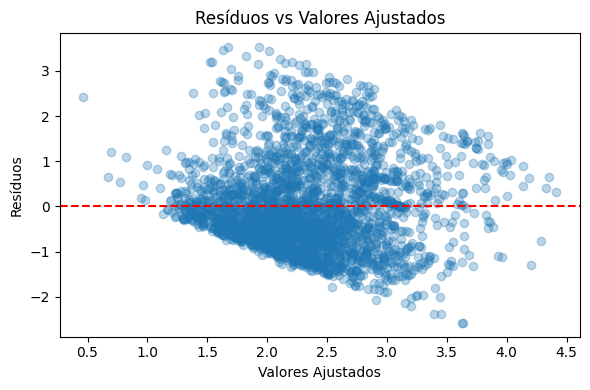

In [13]:
residuals = y_train_sm - ols_results.fittedvalues

plt.figure(figsize=(6, 4))
plt.scatter(ols_results.fittedvalues, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores Ajustados")
plt.tight_layout()
plt.show()

## Avaliação do Modelo Linear (B2)

A regressão linear apresentou desempenho superior ao baseline de persistência, reduzindo o erro médio absoluto\
de aproximadamente 1.16 (em validação) para 0.9. Esse resultado indica que as variáveis de processo fornecem\
informação preditiva relevante além da simples inércia temporal.

Embora o coeficiente de determinação seja moderado, esse comportamento é esperado em sistemas industriais complexos,\
sujeitos a ruído de medição, defasagens não observadas e fatores não instrumentados.

A análise dos resíduos e dos indicadores estatísticos revela a presença de multicolinearidade e autocorrelação\
residual, reflexo direto da engenharia de features baseada em múltiplas defasagens e estatísticas agregadas.\
Esses aspectos limitam a interpretação isolada dos coeficientes, mas não comprometem o valor preditivo do modelo.

De forma geral, os resultados reforçam a viabilidade do uso de ciência de dados para antecipar variações na qualidade\
do concentrado, ao mesmo tempo em que evidenciam oportunidades claras para abordagens mais sofisticadas em etapas futuras.

1. **Desempenho preditivo**
   - MAE do modelo linear: **≈ 0.90**
   - MAE do baseline de persistência: **≈ 1.16**
   - Redução absoluta do erro: **≈ 0.25**
   - Ganho relativo aproximado: **~22%**

2. **Capacidade explicativa**
   - R²: **0.23**
   - R² ajustado: **0.20**
   - Número de observações: **2.858**
   - Número de variáveis explicativas: **100**

3. **Significância global**
   - Estatística F: **8.23**
   - p-valor (F-statistic): **7.25e-97**
   - Evidência estatística de relação global entre variáveis e target

4. **Multicolinearidade**
   - Condition Number: **≈ 1.03 × 10¹⁶**
   - Menor autovalor da matriz de projeto: **≈ 8.7 × 10⁻²²**
   - Indícios fortes de colinearidade estrutural entre as features

5. **Comportamento dos resíduos**
   - Durbin–Watson: **0.657**
   - Indício de autocorrelação residual positiva
   - Resíduos não homocedásticos (padrão em funil observado)

6. **Distribuição dos erros**
   - Omnibus: **297.06** (p < 0.001)
   - Jarque–Bera: **394.07** (p ≈ 2.7e-86)
   - Skewness: **0.87**
   - Kurtosis: **3.51**
   - Rejeição da hipótese de normalidade dos resíduos


# OLS com regularização

Dada a elevada multicolinearidade observada no espaço de features, é preciso avaliar versões regularizadas da regressão linear utilizando\
o método `fit_regularized` do statsmodels.\
\
A regularização L2 (Ridge) é empregada para estabilizar os coeficientes mantendo todas as variáveis, enquanto a regularização L1 (Lasso)\
é utilizada como mecanismo de seleção automática de features.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# statsmodels trabalha com array ou DataFrame
X_train_sm = sm.add_constant(X_train_scaled)
X_val_sm   = sm.add_constant(X_val_scaled)
X_test_sm  = sm.add_constant(X_test_scaled)

## Ridge

In [15]:
alphas = np.logspace(-3, 3, 20)

ridge_results = []

for alpha in alphas:
    ridge_model = sm.OLS(y_train, X_train_sm)
    
    ridge_res = ridge_model.fit_regularized(
        alpha=alpha,
        L1_wt=0.0  # Ridge
    )
    
    y_val_pred = ridge_res.predict(X_val_sm)
    
    ridge_results.append({
        "alpha": alpha,
        "mae_val": mean_absolute_error(y_val, y_val_pred)
    })

ridge_results = pd.DataFrame(ridge_results)
ridge_results.sort_values("mae_val").head()

,alpha,mae_val
7,0.162378,0.808800
6,0.078476,0.833990
8,0.335982,0.844753
5,0.037927,0.860822
4,0.018330,0.879240


* Ridge Final

In [95]:
best_alpha_ridge = ridge_results.sort_values("mae_val").iloc[0]["alpha"]

ridge_final = sm.OLS(y_train, X_train_sm).fit_regularized(
    alpha=best_alpha_ridge,
    L1_wt=0.0
)

y_val_pred_ridge = ridge_final.predict(X_val_sm)
mae_ridge_val = mean_absolute_error(y_val, y_val_pred_ridge)
mape_ridge_val = mean_absolute_percentage_error(y_val, y_val_pred_ridge)
print("validação:",mae_ridge_val, mape_ridge_val)

y_test_pred_ridge = ridge_final.predict(X_test_sm)
mae_ridge_test = mean_absolute_error(y_test, y_test_pred_ridge)
mape_ridge_test = mean_absolute_percentage_error(y_test, y_test_pred_ridge)
print("teste:",mae_ridge_test, mape_ridge_test)

validação: 0.8087996049688035 0.3621939062170865
teste: 0.9846298543256805 0.42090003755780797


### Features Ridge

In [ ]:
# No statsmodels regularizado, .params já retorna um array numpy
coef_ridge = pd.Series(
    ridge_final.params,  # Removido o .values daqui
    index=["const"] + list(X_train.columns)
)

# Criando o DataFrame de visualização
df_features_ridge = pd.DataFrame({
    'Feature': coef_ridge.index,
    'Coeficiente': coef_ridge.values
})

# Ordenando pelo impacto (valor absoluto) para ver o que mais afeta o tráfego
df_features_ridge['Abs_Coef'] = df_features_ridge['Coeficiente'].abs()
df_features_ridge = df_features_ridge.sort_values(by='Abs_Coef', ascending=False).drop(columns=['Abs_Coef'])

# Exibindo o resultado
pd.set_option('display.max_rows', 100) # Como você pediu antes, para ver tudo
df_features_ridge.head()

,Feature,Coeficiente
0,const,1.997854
14,Flotation Column 01 Air Flow_mean_lag1h,-0.220233
19,Flotation Column 04 Air Flow_mean_lag1h,0.194367
6,Amina Flow_mean_lag1h,0.100487
35,Flotation Column 05 Level_mean_lag1h,-0.095029


In [ ]:
# Filtrando apenas o que tem impacto real (ex: coef > 0.001)
features_relevantes = df_features_ridge[df_features_ridge['Coeficiente'].abs() > 0.01]
features_relevantes

,Feature,Coeficiente
0,const,1.997854
14,Flotation Column 01 Air Flow_mean_lag1h,-0.220233
19,Flotation Column 04 Air Flow_mean_lag1h,0.194367
6,Amina Flow_mean_lag1h,0.100487
35,Flotation Column 05 Level_mean_lag1h,-0.095029
16,Flotation Column 02 Air Flow_mean_lag1h,-0.090226
89,Flotation Column 04 Air Flow_std_lag3h,-0.078343
95,Flotation Column 02 Level_mean_lag3h,-0.071020
56,Flotation Column 04 Air Flow_std_lag2h,-0.064871
29,Flotation Column 02 Level_mean_lag1h,-0.064011


## Lasso

In [ ]:
# O sklearn será usado aqui apenas pq a busca pelos alphas é mais rápida por lá
alphas = np.logspace(-4, 1, 50)
model_cv = LassoCV(alphas=alphas, cv=5, random_state=RANDOM_SEED, max_iter=10000, tol=1e-4)
model_cv.fit(X_train_sm, y_train)

best_alpha_sklearn = model_cv.alpha_
print(f"Melhor Alpha encontrado pelo Sklearn: {best_alpha_sklearn}")

Melhor Alpha encontrado pelo Sklearn: 0.028117686979742307


* Lasso Final

In [70]:
lasso_final = sm.OLS(y_train, X_train_sm).fit_regularized(
    alpha=best_alpha_sklearn,
    L1_wt=1.0,
    maxiter=10000
)

y_val_pred_lasso = lasso_final.predict(X_val_sm)
mae_lasso_val = mean_absolute_error(y_val, y_val_pred_lasso)
mape_lasso_val = mean_absolute_percentage_error(y_val, y_val_pred_lasso)
mae_lasso_val, mape_lasso_val

(0.8580727669465528, 0.44566979703426896)

In [71]:
y_test_pred_lasso = lasso_final.predict(X_test_sm)
mae_lasso_test = mean_absolute_error(y_test, y_test_pred_lasso)
mape_lasso_test = mean_absolute_percentage_error(y_test, y_test_pred_lasso)
mae_lasso_test, mape_lasso_test

(0.9734624075490269, 0.4502180489519537)

### Features do Lasso

In [82]:
coef_lasso = pd.Series(
    lasso_final.params.values, 
    index=["const"] + list(X_train.columns)
)

features_vivas = coef_lasso[coef_lasso != 0].sort_values()
features_vivas

Flotation Column 01 Air Flow_mean_lag1h   -0.334497
Flotation Column 05 Level_mean_lag1h      -0.093374
Flotation Column 04 Air Flow_std_lag3h    -0.065301
Ore Pulp pH_mean_lag3h                    -0.049987
Flotation Column 02 Level_mean_lag1h      -0.047981
Starch Flow_mean_lag1h                    -0.042366
Ore Pulp pH_mean_lag1h                    -0.038858
Amina Flow_std_lag3h                      -0.031813
Flotation Column 04 Air Flow_std_lag2h    -0.030319
Flotation Column 02 Level_mean_lag3h      -0.024094
Flotation Column 02 Level_std_lag2h       -0.021839
Ore Pulp Density_std_lag2h                -0.020126
Flotation Column 02 Level_std_lag3h       -0.017268
Flotation Column 03 Level_std_lag2h       -0.016466
Ore Pulp Density_std_lag1h                -0.014243
Starch Flow_std_lag1h                     -0.012238
Flotation Column 02 Level_std_lag1h       -0.010955
Starch Flow_std_lag3h                     -0.008886
Flotation Column 03 Level_std_lag1h       -0.008260
Flotation Co

In [96]:
len(features_vivas)

32

In [100]:
pd.DataFrame(features_vivas).to_parquet(
    PROCESSED_DATA_DIR / "lasso_features_vivas.parquet",
    index=False
)

# Lasso Multioutput

In [ ]:
target_window = 6
modelos_6h = {}

X_df = pd.DataFrame(X_train_sm, index=y_train.index)
for h in range(1, target_window + 1):
    y_h = y_train.shift(-h).dropna()
    X_h = X_df.loc[y_h.index]
    
    model = sm.OLS(y_h, X_h).fit_regularized(
        alpha=best_alpha_sklearn,
        L1_wt=1.0,
        maxiter=10000
    )
    
    modelos_6h[f'T+{h}'] = model
    print(f"Modelo para T+{h} treinado com Lasso.")

Modelo para T+1 treinado com Lasso.
Modelo para T+2 treinado com Lasso.
Modelo para T+3 treinado com Lasso.
Modelo para T+4 treinado com Lasso.
Modelo para T+5 treinado com Lasso.
Modelo para T+6 treinado com Lasso.


In [109]:
input_atual = X_val_sm[-1:].copy() 
resultado_janela = {}
for h, res in modelos_6h.items():
    pred = res.predict(input_atual)
    resultado_janela[h] = pred[0]

df_previsao = pd.Series(resultado_janela)
print("Projeção para a Janela de 6 Horas (Teor de Sílica):")
print(df_previsao)

Projeção para a Janela de 6 Horas (Teor de Sílica):
T+1    2.793999
T+2    2.765837
T+3    2.649794
T+4    2.615573
T+5    2.785092
T+6    2.802939
dtype: float64


In [ ]:
input_atual = X_test_sm[-1:].copy() 
resultado_janela = {}
for h, res in modelos_6h.items():
    pred = res.predict(input_atual)
    resultado_janela[h] = pred[0]

df_previsao = pd.Series(resultado_janela)
print("Projeção para a Janela de 6 Horas (Teor de Sílica):")
print(df_previsao)

Projeção para a Janela de 6 Horas (Teor de Sílica):
T+1    2.319276
T+2    2.409021
T+3    2.466963
T+4    2.426147
T+5    2.286400
T+6    1.892486
dtype: float64


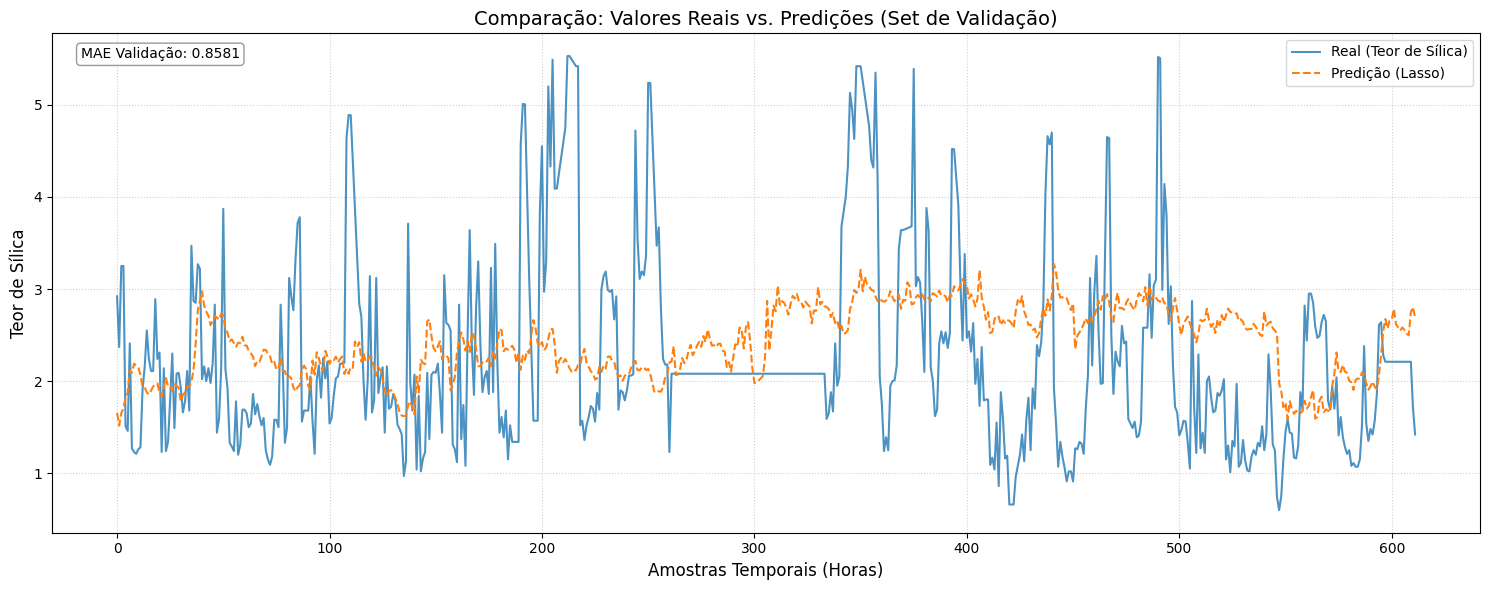

In [110]:
y_val_pred = lasso_final.predict(X_val_sm)

plt.figure(figsize=(15, 6))
plt.plot(y_val.values, label='Real (Teor de Sílica)', color='#1f77b4', linewidth=1.5, alpha=0.8)
plt.plot(y_val_pred, label='Predição (Lasso)', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.title('Comparação: Valores Reais vs. Predições (Set de Validação)', fontsize=14)
plt.xlabel('Amostras Temporais (Horas)', fontsize=12)
plt.ylabel('Teor de Sílica', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# Adicionando o MAE no gráfico para referência
mae_val = np.mean(np.abs(y_val.values - y_val_pred))
plt.annotate(f'MAE Validação: {mae_val:.4f}', 
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

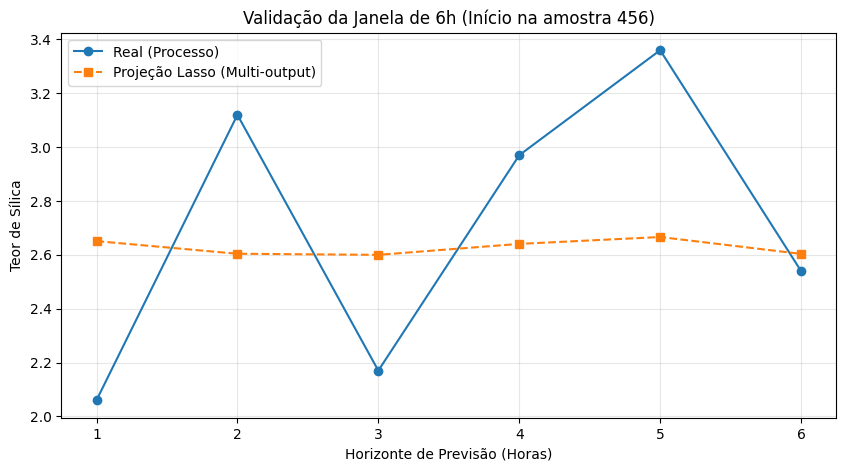

In [120]:
# 1. Escolher um ponto de partida na validação (ex: amostra 100)
ponto_inicio = 456 
input_viva = X_val_sm[ponto_inicio : ponto_inicio + 1]

projeção = []
for h in range(1, 7):
    pred = modelos_6h[f'T+{h}'].predict(input_viva)[0]
    projeção.append(pred)

real = y_val.iloc[ponto_inicio + 1 : ponto_inicio + 7].values

plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), real, marker='o', label='Real (Processo)', color='#1f77b4')
plt.plot(range(1, 7), projeção, marker='s', linestyle='--', label='Projeção Lasso (Multi-output)', color='#ff7f0e')

plt.title(f'Validação da Janela de 6h (Início na amostra {ponto_inicio})')
plt.xlabel('Horizonte de Previsão (Horas)')
plt.ylabel('Teor de Sílica')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Síntese Comparativa dos Modelos Avaliados

## 1. Baseline Naive (Persistência)

* A melhor previsão para o próximo período é o último valor observado do target.

Resultados
* **MAE (validação):** ≈ 1.16
* **MAE (teste):** ≈ 1.11
* **MAPE (teste):** ≈ 35.6%

Leitura
* Difícil de superar devido à alta autocorrelação horária do teor de sílica.
* Serve como linha mínima de desempenho operacional.
* Não utiliza nenhuma variável de processo $\rightarrow$ zero capacidade explicativa.

## 2. OLS Clássico (Regressão Linear sem Regularização)

* As variáveis de processo, agregadas e defasadas, carregam informação adicional além da inércia temporal.

Resultados
* **MAE (validação):** ≈ 0.91
* **MAE (teste):** ≈ 1.05
* **MAPE (teste):** ≈ 48.3%
* **$R^2$:** 0.23 | **$R^2$ ajustado:** 0.20

Leitura
* Supera claramente o baseline naive em validação.
* Ganho absoluto de erro ≈ 0.25 (≈ 22%).
* Evidência estatística global forte (F-test altamente significativo).
* **Problemas estruturais severos:**
    * Multicolinearidade extrema (Condition Number ≈ 1e16).
    * Autocorrelação residual (Durbin–Watson ≈ 0.66).
    * Resíduos não normais e heterocedásticos.
* Excelente como modelo diagnóstico, fraco como modelo estável.

## 3. OLS com Regularização Ridge (L2)

* Reduzir a variância dos coeficientes mantendo todas as features melhora estabilidade e generalização.

Resultados
* **MAE (validação):** ≈ 0.81
* **MAE (teste):** ≈ 0.98
* **MAPE (teste):** ≈ 42.1%
* **Melhor $\alpha$:** ≈ 0.16

Leitura
* Melhora consistente em relação ao OLS puro.
* Redução clara da instabilidade causada por colinearidade.
* Mantém todas as variáveis $\rightarrow$ interpretação global preservada.
* Modelo mais robusto e operacionalmente seguro que o OLS clássico.

## 4. OLS com Regularização Lasso (L1)

* Selecionar automaticamente um subconjunto de variáveis relevantes melhora generalização e interpretabilidade.

Resultados
* **MAE (validação):** ≈ 0.86
* **MAE (teste):** ≈ 0.97
* **MAPE (teste):** ≈ 45.0%
* **Variáveis ativas:** ~30–35 (de 106)

Leitura
* **Melhor desempenho geral** entre os modelos lineares.
* Elimina redundâncias estruturais criadas por múltiplas defasagens.
* Produz um modelo parcimonioso e interpretável.
* Excelente ponte entre modelagem estatística e uso prático no processo.

# Limitações do Estudo

1. **Desalinhamento temporal latente:** O target representa um agregado de processo cujo tempo efetivo de residência não é explicitamente conhecido.
2. **Defasagens fixas simplificam um fenômeno dinâmico:** O uso de janelas horárias assume tempos de resposta constantes, o que não reflete totalmente a realidade operacional.
3. **Ruído operacional e medição manual:** A inserção manual dos dados laboratoriais adiciona variabilidade não modelada.
4. **Alta colinearidade estrutural:** Derivada da engenharia de features baseada em múltiplas estatísticas e lags correlacionados.
5. **Modelos propositalmente simples:** Esta etapa não explora modelos não lineares, interações complexas ou aprendizado temporal profundo.

# Revelações para o Negócio

* **O processo é previsível com antecedência útil:** Mesmo modelos simples conseguem antecipar variações relevantes no teor de sílica.
* **Variáveis de flotação têm impacto consistente:** Vazões de ar, níveis de coluna, dosagem de reagentes e densidade aparecem de forma recorrente nos modelos.
* **Controle preventivo é viável:** Há potencial real para agir antes da medição laboratorial, reduzindo retrabalho e perdas de qualidade.
* **Simplicidade já gera valor:** Não é necessário começar com modelos complexos para obter ganhos operacionais mensuráveis.
* **Base sólida para evolução:** Os resultados justificam investimentos em modelos dinâmicos (ML temporal), integração com controle de processo e monitoramento de *drift*.